In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
# from scipy.integrate import RK45

import sympy as sym

# from table_maker import *
from functools import partial
# from itertools import *

import pickle

import helper_symbolics

from functools import partial

from tqdm import tqdm

# from scipy import interpolate
from numpy.polynomial import Polynomial

import scipy.stats
from scipy.signal import fftconvolve

from math import ceil

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Adapted from [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,y) q(y,t) f\big( u(y,t)\big) \ dy \\
    \alpha q_t &= 1 - q - \alpha\beta q f(u) \\
\end{align*}$$

In [3]:
U_style = {
    'linestyle' : '-'
}

Q_style = {
    'linestyle' : '--'
}

threshold_style = {
    'linestyle': ':',
    'color': 'k'
}

sol1_style = {
    'color' : 'b'
}

sol2_style = {
    'color' : 'g'
}

sol3_style = {
    'color' : 'm'
}

In [4]:
params = {
    'theta' :  0.2,
    'alpha' : 20.0,
    'beta'  :  0.25,
    'mu'    :  1.0
}

###############################################

a, b = -50, 100
n = 10**4

###############################################
xs = np.linspace(a,b,n)
h = (b-a)/(n-1)

def firing_rate(u, theta):
    return np.heaviside(u-theta, .5)
    
M = .5*np.exp( - np.abs( np.subtract.outer(xs, xs) ) ) * h
def convW_mat(ys):
    return M@ys

kernel_half_width = ceil(16/h*np.log(10))
kernel_xs = np.arange(-kernel_half_width, kernel_half_width+1)*h
kernel = h*.5*np.exp(-np.abs(kernel_xs))
def convW_fft(ys):
    return fftconvolve(ys, kernel, mode='same')

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

def euler_step(F, t, u, dt):
    return u + dt*F(t, u)

# u is a vector [u, q]
def F_with_params(t, u, *, theta, alpha, beta, mu, convW):
    temp_var = firing_rate(u[0], theta)
    ret = np.array([
        1/mu * (-u[0] + convW(u[1]*temp_var)),
        (1-u[1])/alpha - beta*u[1]*temp_var
    ])
    return ret

def find_root_indices(y):
    root_mask = y[1:]*y[:-1] < 0
    return np.arange(len(y)-1)[root_mask]

def find_roots(xs, ys, window=2):
    roots = []
    for root_index in find_root_indices(ys):
        start_index = root_index-window//2
        locs = slice(start_index, start_index+window)
        p = Polynomial.fit(xs[locs], ys[locs], window-1)
        p_prime = p.deriv()
        x = xs[root_index]
        for _ in range(5):
            x -= p(x)/p_prime(x)
        if not xs[root_index-1] < x < xs[root_index]+1:
            x = xs[root_index]
        roots.append(x)
    return roots

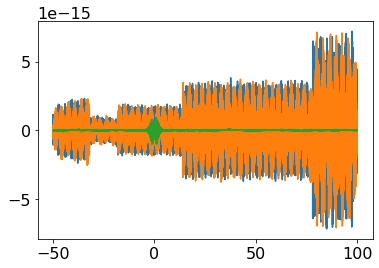

In [5]:
kernel_half_width = ceil(16/h*np.log(10))
kernel_xs = np.arange(-kernel_half_width, kernel_half_width+1)*h
kernel = h*.5*np.exp(-np.abs(kernel_xs))
for f in [np.sin, np.cos, lambda x: np.exp(-x**2)]:
    ys = f(xs)
    plt.plot(xs, convW_mat(ys) - convW_fft(ys))
    # plt.plot(xs, M@f(xs))
plt.show()

In [6]:
# %%timeit
# convW_mat(xs)

44.4 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# %%timeit
# convW_fft(xs)

369 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
F = partial(F_with_params, convW=convW_fft, **params)
# Load numerical functions
numerical_params = helper_symbolics.get_numerical_parameters(params, precision=15)
c = float([v for k, v in numerical_params.items() if str(k) == 'c'][0])
pulse_width = float([v for k, v in numerical_params.items() if str(k) == '\\Delta'][0])
for k, v in numerical_params.items():
    print(f'{k} = {v}')
U, Q, U_prime, Q_prime = helper_symbolics.get_traveling_pulse(numerical_params, validate=False)
v1, v2 = helper_symbolics.get_adjoint_nullspace(numerical_params, validate=False)

\theta = 0.2000
\alpha = 20.00
\beta = 0.2500
\mu = 1.000
c = 1.03002856613383
\Delta = 9.34267426461180
A_0 = 0.9999999999993554
A_{-\Delta} = -2.754901823953583e-08
C1 = -1.1351331181501658e-06


In [9]:
u0 = np.zeros((2,n))

# def cos_bell(x, center=0, width=2*np.pi, height=1):
#     return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)
# u0[0] = cos_bell(xs, center=0, width=100)
# u0[1] += 1 # Set initial q to 1

u0[0] = U(xs-20)
u0[1] = Q(xs-20)

t0 = 0
t_final = 30
k = 1e-3

time_integrator = euler_step
# time_integrator = RK4_step    

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in tqdm(range(steps)):
    ts += [ts[-1] + k]
    u_new = time_integrator(F, ts[-1], us[-1], k)
    us.append(u_new)

100%|██████████| 30000/30000 [00:16<00:00, 1799.06it/s]


In [10]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

frames = 200

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], label="$u$", **U_style, **sol1_style)
line_q, = ax.plot(xs, us[0][1], label="$q$", **Q_style, **sol1_style)
ax.plot([a, b], [params['theta']]*2, **threshold_style)
ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(0, b)
# ax.set_xlim(a,b)

def animate(i):
    #print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(0, len(ts), len(ts)//frames)), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('negative-feedback_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

100%|█████████▉| 200/201 [00:06<00:00, 28.57it/s]


In [27]:
u0 = np.zeros((2,n))

x0 = 0

u0[0] = U(xs - x0)
u0[1] = Q(xs - x0)

t0 = 0
t_final = 10
k = 1e-3 / 5

time_integrator = euler_step

t_pulse = 1
pulse_amp = .01


########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in tqdm(range(steps)):
    ts.append(ts[-1] + k)
    u_new = time_integrator(F, ts[-1], us[-1], k)
    if abs(ts[-1] - t_pulse) < k/2:
        u_new[0] += pulse_amp
    us.append(u_new)
    
ts = np.array(ts)

100%|██████████| 50000/50000 [00:31<00:00, 1608.15it/s]


In [26]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

frames = 200

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], label="$u$", **U_style, **sol1_style)
line_q, = ax.plot(xs, us[0][1], label="$q$", **Q_style, **sol1_style)
ax.plot([a, b], [params['theta']]*2, **threshold_style)

line_u_before, = ax.plot(xs, U(xs - x0), **U_style, **sol2_style)
line_q_before, = ax.plot(xs, Q(xs - x0), **Q_style, **sol2_style)

ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(-15, 60)
# ax.set_xlim(a,b)

def animate(i):
    #print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    t = t0 + k*i
    xis = xs - x0 - c*t
    line_u_before.set_ydata(U(xis))
    line_q_before.set_ydata(Q(xis))
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(0, len(ts), len(ts)//frames)), init_func=init,
                              interval=1/24*1000, blit=True)

anim.save('working.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

100%|█████████▉| 200/201 [00:09<00:00, 21.90it/s]


In [28]:
def integrate(ys, h):
    return np.sum(ys)*h

response = -integrate(v1(xs)*pulse_amp, h) / integrate(params['mu']*U_prime(xs)*v1(xs) + params['alpha']*Q_prime(xs)*v2(xs), h)
fore_fronts = [find_roots(xs, u-params['theta'], window=7)[-1] for u, q in us]

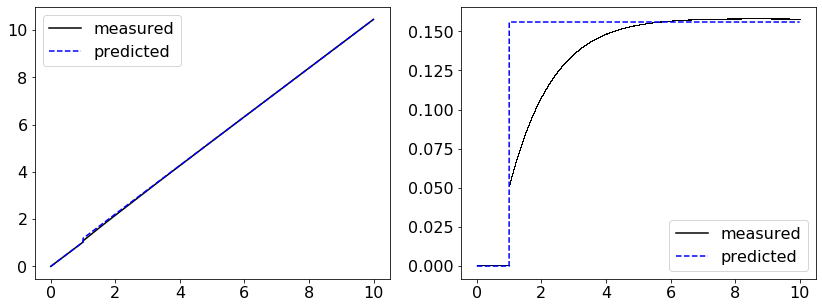

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(ts, fore_fronts, 'k-', label='measured')
axes[0].plot(ts, c*ts-x0 + np.heaviside(ts-t_pulse,0)*response, 'b--', label='predicted')
axes[0].legend()

axes[1].plot([], [], 'k-', label='measured')
axes[1].plot(ts, fore_fronts - c*ts, 'k,')
axes[1].plot(ts, np.heaviside(ts-t_pulse,0)*response, 'b--', label='predicted')
axes[1].legend()
plt.savefig('wave_response_small.png')
plt.show()

Hmmm... maybe a sign error somewhere? The magnitude is off too.

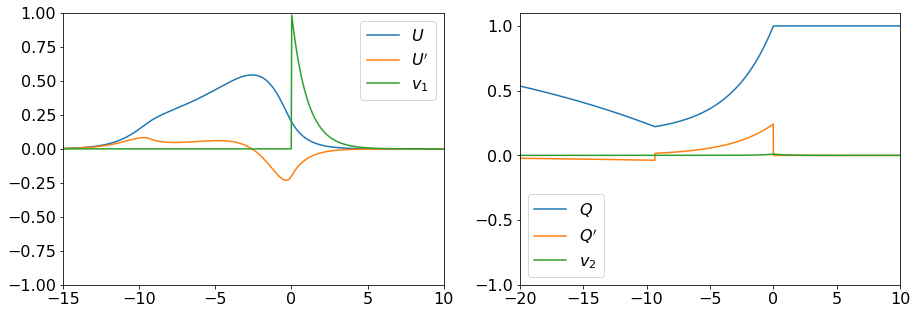

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(xs, U(xs), label=r'$U$')
axes[0].plot(xs, U_prime(xs), label=r'$U^\prime$')
axes[0].plot(xs, v1(xs), label=r'$v_1$')
axes[0].set_ylim(-1, 1)
axes[0].set_xlim(-15, 10)
axes[0].legend()

axes[1].plot(xs, Q(xs), label=r'$Q$')
axes[1].plot(xs, Q_prime(xs), label=r'$Q^\prime$')
axes[1].plot(xs, v2(xs), label='$v_2$')
axes[1].set_ylim(-1, 1.1)
axes[1].set_xlim(-20, 10)
axes[1].legend()

# plt.savefig('nullspace.png')
plt.show()

# Nullspace profile

In [39]:
v1_list = []
zs = np.linspace(-12, 5, 501)
epsilon = 0.01

###############################################
t0 = 0
t_final = 15
k = 1e-3

def I(x0):
    width = 5
    sd = (xs[-1] - xs[0])/(len(xs) -1 ) * width
    return scipy.stats.norm(loc=x0, scale = sd).pdf(xs)

for z in tqdm(zs):
    u0 = np.zeros((2,n))

    u0[0] = U(xs) + I(z)*epsilon
    u0[1] = Q(xs)
    time_integrator = euler_step
    ########################
    steps = int(np.ceil( (t_final - t0)/k ))
    k = (t_final - t0)/steps

    us = u0
    t = t0

    for step in range(steps):
        t = t + k
        us = time_integrator(F, t, us, k)
        
    _, root = find_roots(xs, us[0]-params['theta'], window=5)
    v1_list.append((root - c*t)/epsilon)

100%|██████████| 501/501 [1:05:30<00:00,  7.84s/it]


In [17]:
# plt.plot(xs, us[0], **U_style, **sol1_style)
# plt.plot(xs, us[0], **Q_style, **sol1_style)
# plt.plot(xs, U(xs-c*t), **U_style, **sol2_style)
# plt.plot(xs, Q(xs-c*t), **Q_style, **sol2_style)

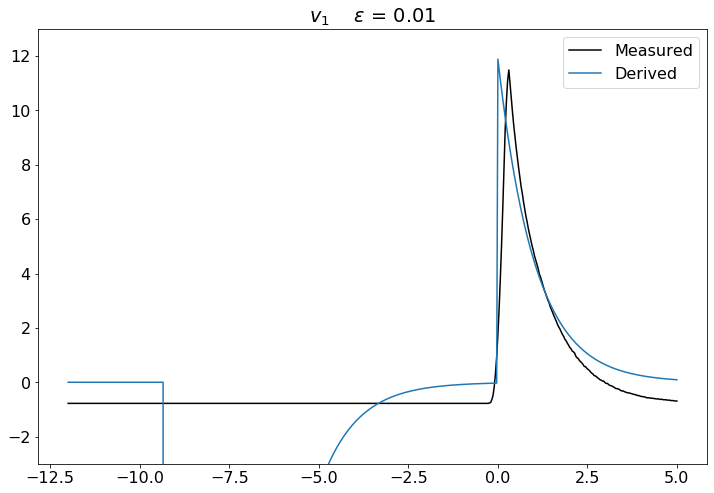

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(zs, v1_list, 'k-', label='Measured')
plt.plot(zs, 12*v1(zs), label='Derived')
plt.title(f'$v_1$\t $\epsilon$ = {epsilon}')
plt.ylim(-3, 13)
plt.legend()
plt.show()

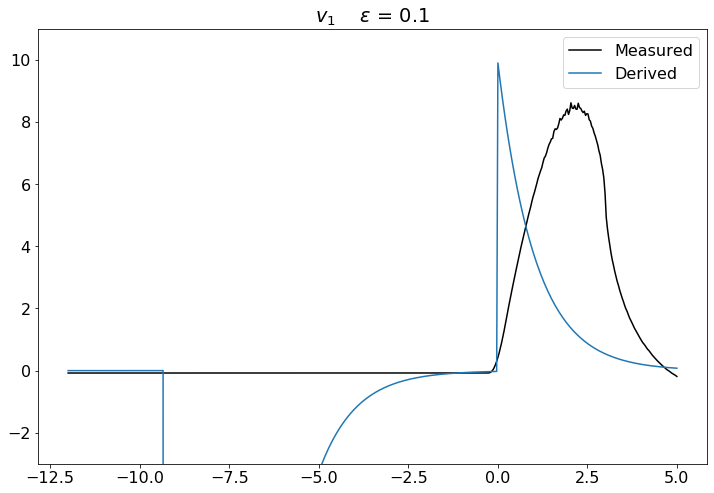

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(zs, v1_list, 'k-', label='Measured')
plt.plot(zs, 10*v1(zs), label='Derived')
plt.title(f'$v_1$\t $\epsilon$ = {epsilon}')
plt.ylim(-3, 11)
plt.legend()
plt.show()

In [54]:
v2_list = []
zs = np.linspace(-12, 5, 201)
epsilon = 0.01

###############################################
t0 = 0
t_final = 15
k = 1e-3

def I(x0):
    width = 5
    sd = (xs[-1] - xs[0])/(len(xs) -1 ) * width
    return scipy.stats.norm(loc=x0, scale = sd).pdf(xs)

for z in tqdm(zs):
    u0 = np.zeros((2,n))

    u0[0] = U(xs)
    u0[1] = Q(xs) + I(z)*epsilon
    time_integrator = euler_step
    ########################
    steps = int(np.ceil( (t_final - t0)/k ))
    k = (t_final - t0)/steps

    us = u0
    t = t0

    for step in range(steps):
        t = t + k
        us = time_integrator(F, t, us, k)
        
    _, root = find_roots(xs, us[0]-params['theta'], window=5)
    v2_list.append((root - c*t)/epsilon)

100%|██████████| 201/201 [29:03<00:00,  8.67s/it]


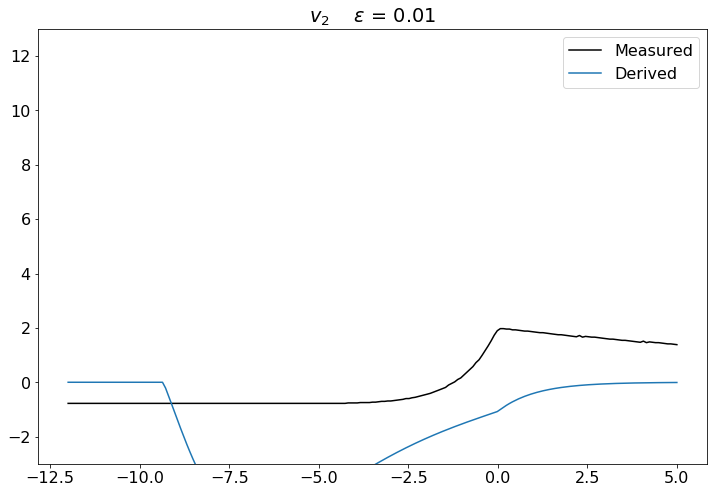

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(zs, v2_list, 'k-', label='Measured')
plt.plot(zs, 12*v2(zs), label='Derived')
plt.title(f'$v_2$\t $\epsilon$ = {epsilon}')
plt.ylim(-3, 13)
plt.legend()
plt.show()

In [19]:
v1_list

[-0.07768169079835019,
 -0.07768169076832976,
 -0.07768168878923731,
 -0.0776816891663401,
 -0.07768169048768314,
 -0.07768169075193398,
 -0.07768169079042764,
 0.10172942058394696,
 7.783193435029894,
 3.0280706260277057,
 -0.18813862593626496]

In [ ]:
# plt.plot(xs, us[0], **U_style, **sol1_style)
# plt.plot(xs, us[1], **Q_style, **sol1_style)

# plt.plot(xs, U(xs - c*t), **U_style, **sol2_style)
# plt.plot(xs, Q(xs - c*t), **Q_style, **sol2_style)

# plt.xlim(c*t - 10, c*t+10)

(-1, 1)

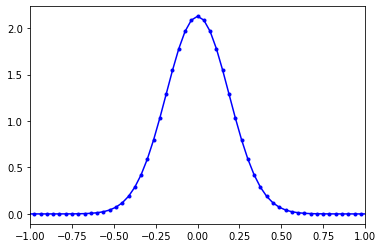

In [49]:
# plt.plot(xs, I(0), 'b.-')
# plt.xlim(-1, 1)

In [22]:
?np.heaviside

Call signature:  np.heaviside(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'heaviside'>
File:            /usr/local/lib/python3.6/dist-packages/numpy/__init__.py
Docstring:      
heaviside(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Compute the Heaviside step function.

The Heaviside step function is defined as::

                          0   if x1 < 0
    heaviside(x1, x2) =  x2   if x1 == 0
                          1   if x1 > 0

where `x2` is often taken to be 0.5, but 0 and 1 are also sometimes used.

Parameters
----------
x1 : array_like
    Input values.
x2 : array_like
    The value of the function when x1 is 0. If ``x1.shape != x2.shape``, they must be broadcastable to a common shape (which becomes the shape of the output).
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broad